In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [102]:
import utils

df = utils.load_data()
ts, covars_diff, covars_nodiff = utils.df2ts(df)


covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(
    covars_nodiff, should_diff=False
)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True)

train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled)
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(
    pd.Timestamp("2016-01-01")
)

# Model Selection

In [103]:
from darts.utils.data import tabularization as tab


lags_past_covariates = {
    "US_CPI": [-2],
    "US_PERSONAL_SPENDING_PCE": [-2],
    "SNP_500": [-2],
    "NEWS_SENTIMENT": [-2],
    "FFED": [-2],
    "US_UNEMPLOYMENT_RATE": [-2],
}
X_train, y_train, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=train_ts_scaled,
    past_covariates=train_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=[-2],
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_train = X_train.squeeze()
y_train = y_train.squeeze()


X_test, y_test, times, last_static_covariates_shape, sample_weight = tab.create_lagged_training_data(
    target_series=val_ts_scaled,
    past_covariates=val_covariates_scaled,
    output_chunk_length=1,
    output_chunk_shift=1,
    lags=[-2],
    lags_past_covariates=lags_past_covariates,
    uses_static_covariates=False,
)
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [104]:
features_cols_names, label_cols_names = tab.create_lagged_component_names(
    ts_scaled, covariates_scaled, lags=[-2], lags_past_covariates=lags_past_covariates, concatenate=False
)

X_train = pd.DataFrame(X_train, columns=features_cols_names)
y_train = pd.DataFrame(y_train, columns=label_cols_names)

X_test = pd.DataFrame(X_test, columns=features_cols_names)
y_test = pd.DataFrame(y_test, columns=label_cols_names)

In [105]:
model = linear_model.LinearRegression()
timeseries_crossval = TimeSeriesSplit(n_splits=5)

sfs = SequentialFeatureSelector(
    model, k_features=(1, 5), scoring="neg_mean_squared_error", forward=True, floating=False, cv=timeseries_crossval
)
selected_features = sfs.fit(X_train, y_train)

X_train = sfs.transform(X_train) #train_df.iloc[:, selected_features.k_feature_idx_]
X_test = sfs.transform(X_test)#test_df.iloc[:, selected_features.k_feature_idx_]

model.fit(X_train, y_train)

pred = model.predict(X_test)

diff = y_test - pred
mse = diff.pow(2).mean()

In [106]:
selected_features.subsets_

{1: {'feature_idx': (5,),
  'cv_scores': array([-0.83020759, -0.57086557, -0.61363643, -0.59063834, -0.40343028]),
  'avg_score': -0.6017556428909302,
  'feature_names': ('FFED_pastcov_lag-2',)},
 2: {'feature_idx': (2, 5),
  'cv_scores': array([-0.84537822, -0.5808897 , -0.59986949, -0.62222117, -0.42087317]),
  'avg_score': -0.6138463497161866,
  'feature_names': ('US_PERSONAL_SPENDING_PCE_pastcov_lag-2',
   'FFED_pastcov_lag-2')},
 3: {'feature_idx': (2, 5, 6),
  'cv_scores': array([-0.93256152, -0.58061296, -0.59879202, -0.61921084, -0.44203317]),
  'avg_score': -0.6346421003341675,
  'feature_names': ('US_PERSONAL_SPENDING_PCE_pastcov_lag-2',
   'FFED_pastcov_lag-2',
   'US_UNEMPLOYMENT_RATE_pastcov_lag-2')},
 4: {'feature_idx': (0, 2, 5, 6),
  'cv_scores': array([-1.03390503, -0.59554285, -0.61080259, -0.62627548, -0.45218483]),
  'avg_score': -0.6637421548366547,
  'feature_names': ('US_TB_YIELD_10YRS_target_lag-2',
   'US_PERSONAL_SPENDING_PCE_pastcov_lag-2',
   'FFED_pastcov_l

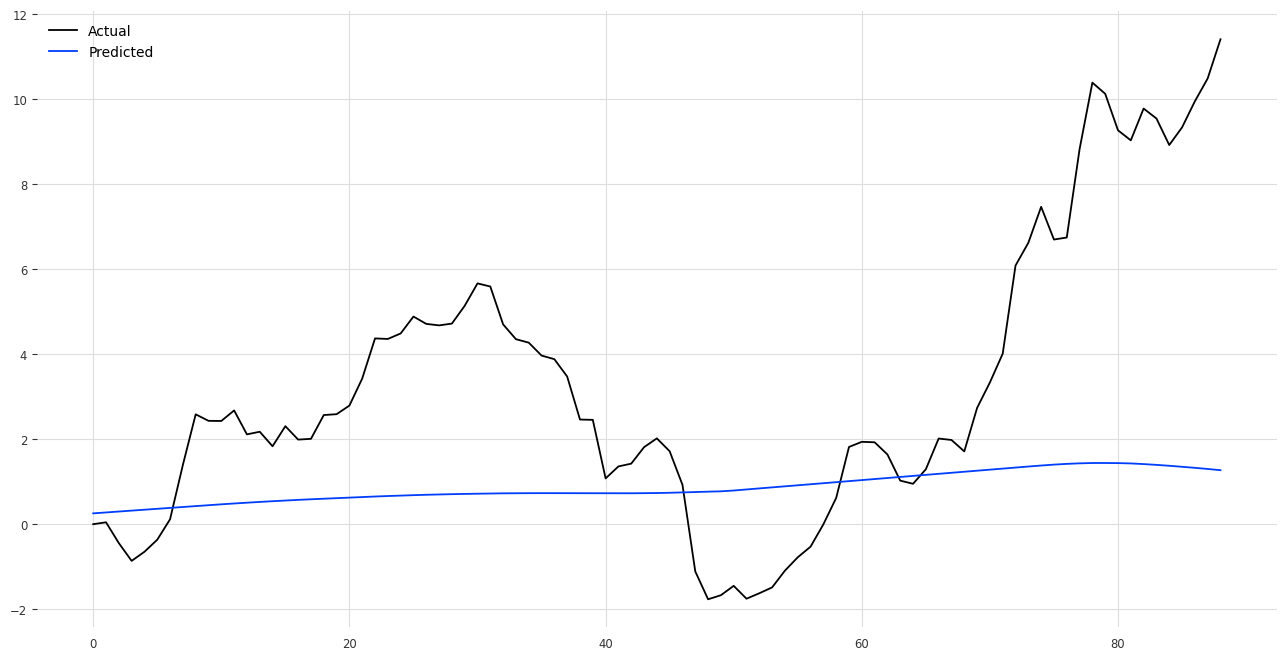

In [113]:
pred = pred.squeeze()

# Plot the results

# Restore the diff column
restored_y_test = y_test.cumsum() + df.loc["2015-12-31", "FFED"]
restored_pred = pd.Series(pred, index=y_test.index).cumsum() + df.loc["2015-12-31", "FFED"]

plt.figure(figsize=(16, 8))
plt.plot(y_test.index, restored_y_test, label="Actual")
plt.plot(y_test.index, restored_pred, label="Predicted")
plt.legend()

In [114]:
sfs.k_feature_names_

('FFED_pastcov_lag-2',)

NameError: name 'plt' is not defined

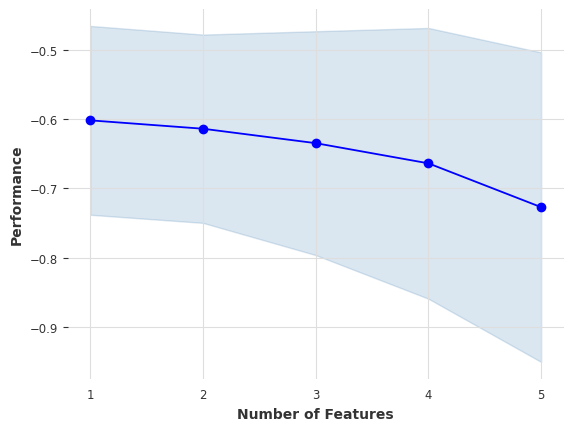

In [83]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_dev")

# plt.ylim([0.8, 1])
plt.title("Sequential Forward Selection (w. StdDev)")
plt.grid()
plt.show()

In [ ]:
def plot_features(features: list[str]):
    features.append("FFED_diff")
    px.line(df, x=df.index, y=features).show()

In [ ]:
plot_features(['US_CPI_EXCL_FOOD_N_ENERGY_diff',
   'CANADA_CPI_diff',
   'US_TB_YIELD_1YR_diff'])

In [ ]:
px.line(df, x=df.index, y=["FFED_diff", ]).show()